In [66]:
import pandas as pd
import numpy as np
from mab2rec.utils import print_interaction_stats
import seaborn as sns
import matplotlib.pyplot as plt
from mab2rec import BanditRecommender, LearningPolicy, NeighborhoodPolicy
from jurity.recommenders import BinaryRecoMetrics, RankingRecoMetrics
from mab2rec.pipeline import benchmark

sns.set_style("whitegrid")
import warnings
from mab2rec.visualization import plot_metrics_at_k
from mab2rec.visualization import plot_intra_diversity_at_k
from crowdkit.aggregation import Wawa
from tqdm.auto import tqdm


def get_num_people_by_age_category(df):
    df["age_group"] = pd.cut(
        x=df["age"], bins=np.arange(90, step=10), labels=np.arange(90, step=10)[:-1]
    )
    return df


full_data = pd.read_csv(
    "./data/ml-100k/u.data",
    names=["user_id", "item_id", "rating"],
    usecols=(0, 1, 2),
    sep="\t",
)
names = ["item_id", "name", "date", "other", "url"] + [f"genre_{i}" for i in range(19)]
item_features = pd.read_csv(
    "./data/ml-100k/u.item", names=names, sep="|", encoding="latin-1"
)
item_features.drop(["other", "name", "date", "url"], axis=1, inplace=True)
item_features.to_csv("./data/ml-100k/item_features.csv", index=False)
test_data = pd.read_csv(
    "./data/ml-100k/ua.test",
    delimiter="\t",
    header=None,
    names=["user_id", "item_id", "rating"],
    usecols=(0, 1, 2),
)
movies_to_keep = pd.DataFrame(full_data["item_id"].value_counts().reset_index()).loc[
    pd.DataFrame(full_data["item_id"].value_counts()).reset_index()["count"] >= 20
]["item_id"]
full_data = full_data.loc[full_data["item_id"].isin(movies_to_keep)]
full_data["rating"] = full_data["rating"] > 4
full_data.columns = ["user_id", "item_id", "response"]
dir_data = "./data/ml-100k/"
user_data = "./../mab2rec/data/" + "features_user.csv"
user_df = pd.read_csv(user_data).set_index("user_id")
item_data = dir_data + "item_features.csv"


In [67]:
by_genre_df = {"user_id": [], "item_id": [], "reward": []}
item_df = pd.read_csv(dir_data + "item_features.csv")
item_df.index = item_df["item_id"]
for i, row in full_data.iterrows():
    item_genre = np.nonzero(item_df.loc[row[1]])[0][1:] - 1
    for genre in item_genre:
        by_genre_df["user_id"].append(row[0])
        by_genre_df["item_id"].append(genre)
        by_genre_df["reward"].append(row[2])
by_genre_df = pd.DataFrame(by_genre_df)
by_genre_df = (
    by_genre_df.groupby(["user_id", "item_id"]).count().reset_index()
)
by_genre_df["response"] = by_genre_df["reward"] > 5
by_genre_df.drop("reward", axis=1, inplace=True)

/tmp/ipykernel_1272354/1919190196.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item_genre = np.nonzero(item_df.loc[row[1]])[0][1:] - 1
/tmp/ipykernel_1272354/1919190196.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  by_genre_df["user_id"].append(row[0])
/tmp/ipykernel_1272354/1919190196.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  by_genre_df["reward"].append(row[2])


In [3]:
class linucb_disjoint_arm:
    def __init__(self, arm_index, d, alpha):
        self.arm_index = arm_index
        self.alpha = alpha
        self.A = np.identity(d)
        self.b = np.zeros([d, 1])

    def calc_UCB(self, x_array):
        A_inv = np.linalg.inv(self.A)
        self.theta = np.dot(A_inv, self.b)
        x = x_array.reshape([-1, 1])
        p = np.dot(self.theta.T, x) + self.alpha * np.sqrt(
            np.dot(x.T, np.dot(A_inv, x))
        )
        return p

    def reward_update(self, reward, x_array):
        x = x_array.reshape([-1, 1])
        self.A += np.dot(x, x.T)
        self.b += reward * x


class linucb_policy:
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [
            linucb_disjoint_arm(arm_index=i, d=d, alpha=alpha) for i in range(K_arms)
        ]

    def select_arm(self, x_array, top=5):
        candidate_arms = []
        arms_ucb = {}
        for arm_index in range(self.K_arms):
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            arms_ucb[arm_index] = arm_ucb

        candidate_arms = sorted(arms_ucb, key=arms_ucb.get, reverse=True)[:top]
        return candidate_arms

In [4]:
def ctr_simulator(df, T, K_arms, d, alpha, verbose=False):
    linucb_policy_object = linucb_policy(K_arms=K_arms, d=d, alpha=alpha)
    aligned_time_steps = [0]
    current_budget = 0
    df_to_use = df.copy()
    for t in tqdm(
        range(T), total=T, disable=not verbose
    ):
        (user, item, reward) = df_to_use.sample(1).values[0]
        user = int(user)
        data_x_array = np.array(
            user_df.loc[user].values
            )
        arm_indexes = linucb_policy_object.select_arm(data_x_array)
        for arm_index in arm_indexes:
            if arm_index == int(item):
                linucb_policy_object.linucb_arms[arm_index].reward_update(
                    reward, data_x_array
                )
                aligned_time_steps.append(aligned_time_steps[-1] + 1)
                current_budget += 1
                break
        else:
            aligned_time_steps.append(aligned_time_steps[-1])
    return (aligned_time_steps, linucb_policy_object)

## Genus only

  0%|          | 0/5 [00:00<?, ?it/s]

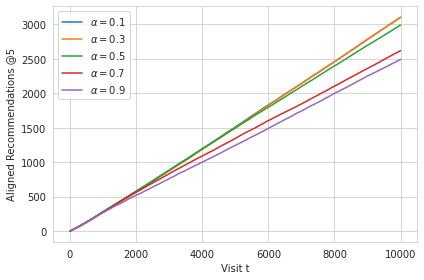

In [5]:
K_arms = by_genre_df["item_id"].max() + 1
d = user_df.loc[1].values.shape[0]
plt.figure()
for alpha in tqdm([.1, .3, .5, .7, .9]):
    all_res = []
    for rep in range(10):
        all_res.append(ctr_simulator(by_genre_df, 10000, K_arms, d, alpha)[0])
    plt.plot(np.mean(all_res, axis=0), label=rf"$\alpha=${alpha}")
plt.xlabel("Visit t")
plt.ylabel("Aligned Recommendations @5")
plt.legend()
plt.tight_layout()
plt.show()

## Mortal bandit for observations: TwoThird

In [22]:
class linucb_policy_mortal:
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [
            linucb_disjoint_arm(arm_index=i, d=d, alpha=alpha) for i in range(K_arms)
        ]

    def select_arm(self, x_array, quality, top=5):
        candidate_arms = []
        arms_ucb = {}
        for arm_index in range(self.K_arms):
            if quality[arm_index] == 1:
                arm_ucb = -1
            else:
                arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            arms_ucb[arm_index] = arm_ucb
        candidate_arms = sorted(arms_ucb, key=arms_ucb.get, reverse=True)[:top]
        return candidate_arms

In [56]:
def ctr_simulator_mortal(df, T, K_arms, d, alpha, verbose=False):
    linucb_policy_object = linucb_policy_mortal(K_arms=K_arms, d=d, alpha=alpha)
    aligned_time_steps = [0]
    current_budget = 0
    df_to_use = df.copy()
    votes = np.zeros((df_to_use["item_id"].max() + 1, 2))
    all_quality = [0]
    quality = np.zeros(df_to_use["item_id"].max() + 1)
    for t in tqdm(range(T), total=T, disable=not verbose):
        (user, item, reward) = df_to_use.sample(1).values[0]
        user = int(user)
        data_x_array = np.array(user_df.loc[user].values)
        arm_indexes = linucb_policy_object.select_arm(data_x_array, quality)
        for arm_index in arm_indexes:
            if arm_index == int(item):
                linucb_policy_object.linucb_arms[arm_index].reward_update(
                    reward, data_x_array
                )
                aligned_time_steps.append(aligned_time_steps[-1] + 1)
                current_budget += 1
                votes[arm_index, int(reward)] += 1
                break
        else:
            aligned_time_steps.append(aligned_time_steps[-1])
        sum_ = votes.sum(axis=1, keepdims=True)
        quality = ((votes / sum_).max(axis=1) > 2/3) * (sum_.flatten() >= 2)
        all_quality.append(quality.sum())
    return (aligned_time_steps, all_quality, votes, linucb_policy_object)

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_1272354/3979661401.py:26: RuntimeWarning: invalid value encountered in divide
  quality = ((votes / sum_).max(axis=1) > 2/3) * (sum_.flatten() >= 2)


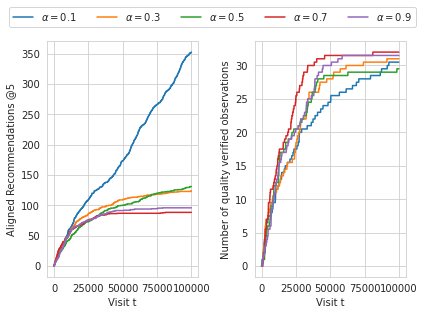

In [59]:
K_arms = full_data["item_id"].max() + 1
d = user_df.loc[1].values.shape[0]
fig, axs = plt.subplots(1, 2)
for alpha in tqdm([0.1, 0.5, 0.9]):
    all_res_mortal = []
    all_quality = []
    for rep in range(10):
        aligned_steps, quality, votes, _ = ctr_simulator_mortal(
            full_data, 100000, K_arms, d, alpha
        )
        all_res_mortal.append(aligned_steps)
        all_quality.append(quality)
    axs[0].plot(np.mean(all_res_mortal, axis=0), label=rf"$\alpha=${alpha}")
    axs[1].plot(np.mean(all_quality, axis=0), label=rf"$\alpha=${alpha}")
plt.legend()
axs[0].set_xlabel("Visit t")
axs[1].set_xlabel("Visit t")
axs[0].set_ylabel("Aligned Recommendations @5")
axs[1].set_ylabel("Number of quality verified observations")
handles, labels = axs[0].get_legend_handles_labels()
# axs[0].get_legend().remove()
axs[1].get_legend().remove()
fig.legend(handles, labels, ncol=5, loc="upper center", bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.savefig("./outputs/online_mortal.pdf", bbox_inches="tight")
plt.show()

## PhyloCrowdRec 

In [196]:
def ctr_simulator_phylocrowd(df_genre, df_votes, T, K_arms, d, alpha, verbose=False):
    linucb_policy_object = linucb_policy_mortal(K_arms=K_arms, d=d, alpha=alpha)
    aligned_time_steps_top_5 = [0]
    aligned_time_steps_top_2 = [0]
    aligned_time_steps_top_1 = [0]
    current_budget = 0
    votes = np.zeros((df_votes["item_id"].max() + 1, 2))
    all_quality = [0]
    genras = df_genre["item_id"].unique()
    pools = {key: [] for key in genras}
    for key in genras:
        pools[key].append(
                item_df["item_id"][np.nonzero(item_df[f"genre_{key}"])[0]+1].values
            )
        pools[key] = pools[key][0]
    quality = np.zeros(df_votes["item_id"].max() + 1)
    for t in tqdm(range(T), total=T, disable=not verbose):
        (user, genre, reward) = df_genre.sample(1).values[0]
        user = int(user)
        data_x_array = np.array(user_df.loc[user].values)
        arm_indexes = linucb_policy_object.select_arm(data_x_array, quality)
        for aa, arm_index in enumerate(arm_indexes):
            arm_index += 1
            if arm_index == int(genre):
                movies = pools[genre]
                linucb_policy_object.linucb_arms[arm_index].reward_update(
                    reward, data_x_array
                )

                current_budget += 1
                tmp_user = df_votes.loc[df_votes["user_id"] == user]
                if any(tmp_user["item_id"].isin(movies)):
                    tmp_user = tmp_user[tmp_user["item_id"].isin(movies)]
                    if any(quality[tmp_user["item_id"].values] == 0):
                        tmp_user = tmp_user.loc[quality[tmp_user["item_id"].values] == 0]
                        if len(tmp_user) > 0:
                            votes_extract = votes[tmp_user["item_id"], :]
                            votes_extract = votes_extract.sum(axis=1)
                            votes_extract_order = np.argsort(votes_extract)[::-1]
                            tmp_user = tmp_user.iloc[votes_extract_order]
                            votes[
                                int(tmp_user["item_id"].values[0]),
                                int(tmp_user["response"].values[0]),
                            ] += 1
                if aa == 0:
                    aligned_time_steps_top_1.append(aligned_time_steps_top_1[-1] + 1)
                else:
                    aligned_time_steps_top_1.append(aligned_time_steps_top_1[-1])
                if aa <= 1:
                    aligned_time_steps_top_2.append(aligned_time_steps_top_2[-1] + 1)
                else:
                    aligned_time_steps_top_2.append(aligned_time_steps_top_2[-1])
                if aa <= 4:
                    aligned_time_steps_top_5.append(aligned_time_steps_top_5[-1] + 1)
                break
        else:
            aligned_time_steps_top_5.append(aligned_time_steps_top_5[-1])
            aligned_time_steps_top_1.append(aligned_time_steps_top_1[-1])
            aligned_time_steps_top_2.append(aligned_time_steps_top_2[-1])

        sum_ = votes.sum(axis=1, keepdims=True)
        quality = ((votes / sum_).max(axis=1) > 2 / 3) * (sum_.flatten() >= 2)
        all_quality.append(quality.sum())
    return ([aligned_time_steps_top_1, aligned_time_steps_top_2,  aligned_time_steps_top_5], all_quality, votes, linucb_policy_object)

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_1272354/1658084796.py:62: RuntimeWarning: invalid value encountered in divide
  quality = ((votes / sum_).max(axis=1) > 2 / 3) * (sum_.flatten() >= 2)
/tmp/ipykernel_1272354/1658084796.py:62: RuntimeWarning: invalid value encountered in divide
  quality = ((votes / sum_).max(axis=1) > 2 / 3) * (sum_.flatten() >= 2)
/tmp/ipykernel_1272354/1658084796.py:62: RuntimeWarning: invalid value encountered in divide
  quality = ((votes / sum_).max(axis=1) > 2 / 3) * (sum_.flatten() >= 2)
/tmp/ipykernel_1272354/1658084796.py:62: RuntimeWarning: invalid value encountered in divide
  quality = ((votes / sum_).max(axis=1) > 2 / 3) * (sum_.flatten() >= 2)
/tmp/ipykernel_1272354/1658084796.py:62: RuntimeWarning: invalid value encountered in divide
  quality = ((votes / sum_).max(axis=1) > 2 / 3) * (sum_.flatten() >= 2)
/tmp/ipykernel_1272354/1658084796.py:62: RuntimeWarning: invalid value encountered in divide
  quality = ((votes / sum_).max(axis=1) > 2 / 3) * (sum_.flatten() >= 2)
/tmp

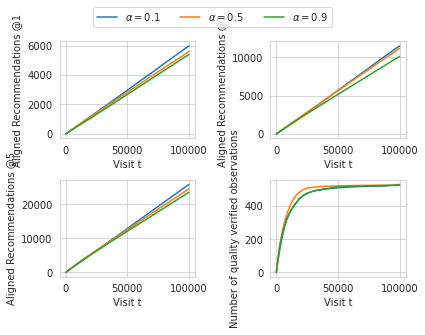

In [198]:
K_arms = by_genre_df["item_id"].nunique() + 1
T = 100000

fig, axs = plt.subplots(2, 2)
for alpha in tqdm([0.1, 0.5, 0.9]):
    all_res_genre_1, all_res_genre_2, all_res_genre_5 = [], [], []
    all_quality_genre = []
    for rep in range(10):
        aligned_steps, quality, votes, _ = ctr_simulator_phylocrowd(
            by_genre_df, full_data, T, K_arms, d, alpha, verbose=False
        )
        all_res_genre_1.append(aligned_steps[0])
        all_res_genre_2.append(aligned_steps[1])
        all_res_genre_5.append(aligned_steps[2])
        all_quality_genre.append(quality)
    axs[0, 0].plot(np.mean(all_res_genre_1, axis=0), label=rf"$\alpha=${alpha}")
    axs[0, 1].plot(np.mean(all_res_genre_2, axis=0), label=rf"$\alpha=${alpha}")
    axs[1, 0].plot(np.mean(all_res_genre_5, axis=0), label=rf"$\alpha=${alpha}")
    axs[1, 1].plot(np.mean(all_quality_genre, axis=0), label=rf"$\alpha=${alpha}")
plt.legend()
axs[0, 0].set_xlabel("Visit t")
axs[1, 0].set_xlabel("Visit t")
axs[0, 1].set_xlabel("Visit t")
axs[1, 1].set_xlabel("Visit t")
axs[0, 0].set_ylabel("Aligned Recommendations @1")
axs[0, 1].set_ylabel("Aligned Recommendations @2")
axs[1, 0].set_ylabel("Aligned Recommendations @5")
axs[1, 1].set_ylabel("Number of quality verified observations")
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[1, 1].get_legend().remove()
fig.legend(handles, labels, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.savefig("./outputs/online_genre.pdf", bbox_inches="tight")
plt.show()

In [203]:
len(np.where(votes > 0)[0])

662

In [204]:
full_data["item_id"].nunique()

939